In [18]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import pickle

from B_data import *
from B_Plotting import Burgers_plot, loss_plot 

# Full PINN
from B_PINN1 import NN1
from B_PINN1_train import pinn1_train
#from B_PINN1_activation import P1
from B_PINN2_ind import NN2
from B_PINN2_train import pinn2_train

# Burgers GPT-PINN
from B_GPT_activation import P

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

# Training Parameter Set
number_of_neurons = 2
nu1_training = np.linspace(1.0, 1.0, number_of_neurons)
nu2_training  = np.linspace(2.0, 2.0, number_of_neurons)

nu_training = []
for i in range(nu1_training.shape[0]):
    for j in range(nu2_training.shape[0]):
        nu_training.append([nu1_training[i],nu2_training[j]])
nu_training = np.array(nu_training)

nu_pinn_train = [1.0,2.0]
largest_loss_list = np.ones(number_of_neurons**2)
P_list = np.ones(number_of_neurons**2, dtype=object)
# Domain and Data
Xi, Xf         = -1.0, 1.5
Ti, Tf         =  0.0, 2/nu_pinn_train[1]
Ti2, Tf2       =  2/nu_pinn_train[1], 1.5
Nx_train, Nt_train =  101, 201
Nx_test, Nt_test = 101, 201
IC_pts, IC_simple = 100, 100
BC_pts =  100
N_RH = IC_pts
dx = 0.001
dt = 0.0002

with open('IFNN_shock2_1020.pkl', 'rb') as f:
#with open('IFNN_shock2_0516.pkl', 'rb') as f:
    IFNN = pickle.load(f)

# Setting PINN and TGPT-PINN
layers_pinn = np.array([2, 30, 30, 30, 30, 30, 1])

lr_pinn1     = 0.001
epochs_pinn1 = 20000
tol_pinn1    = 1e-4

lr_pinn2     = 0.0001
epochs_pinn2 = 25000
tol_pinn2   = 1e-4

lr_gpt          = 0.001
epochs_gpt      = 10000
tol_gpt         = 1e-3

pinn_train_times = np.ones(number_of_neurons)

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [19]:
print("******************************************************************")
########################### Full PINN Training ############################    
residual_data1 = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid1      = residual_data1[0].to(device)
f_hat1         = residual_data1[1].to(device)
xt_test1       = residual_data1[2].to(device)
xt_RHL1      = residual_data1[3].to(device)
xt_RHR1      = residual_data1[4].to(device)
xt_RHt1         = residual_data1[5].to(device)
xt_RHtL1       = residual_data1[6].to(device)
ind = torch.logical_and(xt_resid1[:,0]>-1,xt_resid1[:,0]<1)

BC_data = create_BC_data(Xi, Xf, Ti, Tf, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

IC_data1 = create_IC_data(nu_pinn_train,Xi, Xf, Ti, Tf, IC_pts, IC_simple)
IC_xt1     = IC_data1[0].to(device)
IC_u1      = IC_data1[1].to(device)
#plt.scatter(IC_xt[:,1].detach().cpu(),IC_xt[:,0].detach().cpu(),s=0.1)
xt_en = Move_Time_1D(IC_xt1, Tf).to(device)

Exact_y1 = exact_u(nu_pinn_train,xt_test1)[:,None].to(device)
###   IFNN2 training   ####
pinn_train_time_1 = time.perf_counter()

#PINN1 = NN1(nu_pinn_train, layers_pinn,dt).to(device)    
#pinn1_losses = pinn1_train(PINN1, nu_pinn_train, xt_resid1, IC_xt1, IC_u1, BC1, BC2, xt_RHL1,xt_RHR1,xt_RHt1,xt_RHtL1, f_hat1, Exact_y1, epochs_pinn1, lr_pinn1, tol_pinn1, xt_test1)
PINN1= IFNN[0]
pinn1_losses = IFNN[2]
pinn_train_time_2 = time.perf_counter()
print(f"PINN Training Time: {(pinn_train_time_2-pinn_train_time_1)/3600} Hours")


******************************************************************
PINN Training Time: 1.9901102253546316e-08 Hours


In [20]:
residual_data2 = create_residual_data(Xi, Xf, Ti2, Tf2, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid2      = residual_data2[0].to(device)
f_hat2         = residual_data2[1].to(device)
xt_test2       = residual_data2[2].to(device)
xt_RHL2      = residual_data2[3].to(device)
xt_RHR2      = residual_data2[4].to(device)
xt_RHt2         = residual_data2[5].to(device)
xt_RHtL2       = residual_data2[6].to(device)

BC_data2 = create_BC_data(Xi, Xf, Ti2, Tf2, BC_pts)
BC_bottom2     = BC_data2[0].to(device)
BC_top2        = BC_data2[1].to(device)

IC_data2 = create_IC_data(nu_pinn_train,Xi, Xf, Ti2, Tf2, IC_pts, IC_simple)
IC_xt2     = IC_data2[0].to(device)
IC_u2      = IC_data2[1].to(device)

Exact_y2 = exact_u(nu_pinn_train,xt_test2)[:,None].to(device)
###   IFNN2 training   ####
pinn2_train_time_1 = time.perf_counter()

#PINN2 = NN2(nu_pinn_train,layers_pinn,dt).to(device)    
#pinn2_losses = pinn2_train(PINN2, nu_pinn_train,PINN1, xt_resid2, IC_xt2, IC_u2, BC_bottom2, BC_top2, xt_RHL2,xt_RHR2,xt_RHt2,xt_RHtL2, f_hat2,Exact_y2, epochs_pinn2, lr_pinn2, tol_pinn2, xt_test2)
PINN2 = IFNN[1]
pinn2_losses = IFNN[3]
pinn2_train_time_2 = time.perf_counter()
print(f"PINN2 Training Time: {(pinn2_train_time_2-pinn2_train_time_1)/3600} Hours")

PINN2 Training Time: 2.0732210638622443e-08 Hours


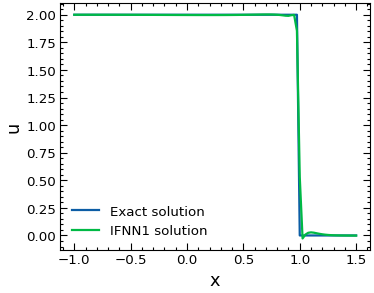

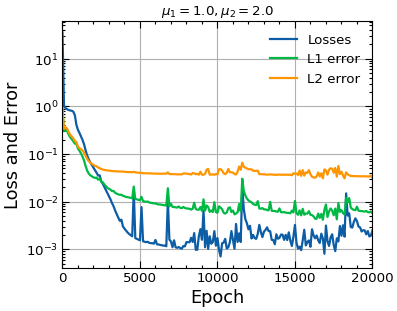

In [21]:
###   Plot1   ###
plt.figure(dpi=80, figsize=(5,4))
plt.plot(xt_test1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),Exact_y1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),label='Exact solution')
plt.plot(xt_test1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),PINN1(xt_test1)[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),label = 'IFNN1 solution')
plt.xlabel("x",     fontsize=16)
plt.ylabel("u",     fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#20
plt.show()

#Burgers_plot(xt_test1, Exact_y1, Nx_test,Nt_test, title=fr"Step1 Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
#Burgers_plot(xt_test1, PINN1(xt_test1),Nx_test,Nt_test, title=fr"IFNN1 Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
#Burgers_plot(xt_test1, abs(PINN1(xt_test1)-Exact_y1), Nx_test,Nt_test,title=fr"IFNN1 Error  $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

plt.figure(dpi=80, figsize=(5,4))    
plt.plot(pinn1_losses[0], pinn1_losses[1], label="Losses")
plt.plot(pinn1_losses[0], pinn1_losses[2], label="L1 error")
plt.plot(pinn1_losses[0], pinn1_losses[3], label="L2 error")
#plt.plot(pinn1_losses[0], pinn1_losses[4], label="Loss_pde")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss and Error", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
plt.xlim(0,max(pinn1_losses[0]))
plt.yscale('log')
plt.title(fr"$\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$", fontsize=12)
plt.legend(fontsize = 12)#
plt.show()
##########################################

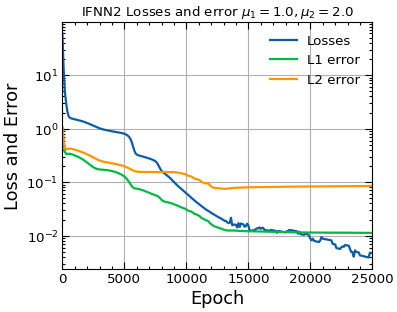

In [22]:
###     Plot2    ###
#Burgers_plot(xt_test2, Exact_y2, Nx_test,Nt_test, title=fr"Step2 Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
#Burgers_plot(xt_test2, PINN2(xt_test2),Nx_test,Nt_test, title=fr"IFNN2 Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
#Burgers_plot(xt_test2, abs(PINN2(xt_test2)-Exact_y2), Nx_test,Nt_test,title=fr"IFNN2 Error  $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

plt.figure(dpi=80, figsize=(5,4))    
plt.plot(pinn2_losses[0], pinn2_losses[1], linewidth=2, label="Losses")
plt.plot(pinn2_losses[0], pinn2_losses[2], linewidth=2, label="L1 error")
plt.plot(pinn2_losses[0], pinn2_losses[3], linewidth=2, label="L2 error")
#plt.plot(pinn2_losses[0], pinn2_losses[4], linewidth=2, label="Loss_pde")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss and Error", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
plt.xlim(0,max(pinn2_losses[0]))
plt.yscale('log')
plt.title(fr"IFNN2 Losses and error $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$", fontsize=12)
plt.legend(fontsize = 12)
plt.show()
###########################################

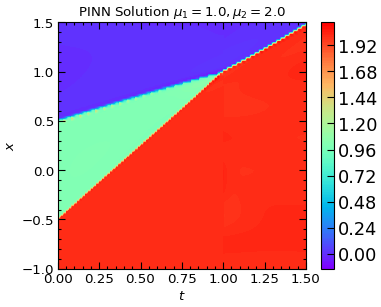

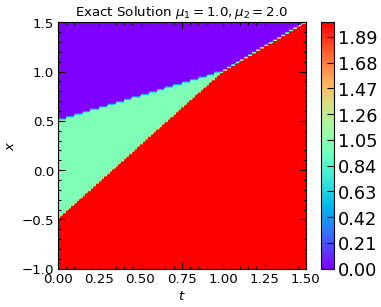

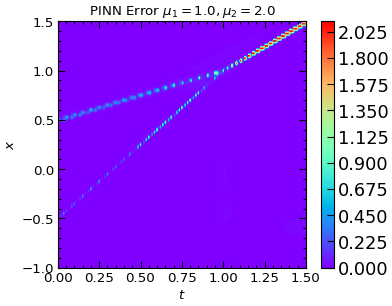

PINN at mu_1=1.0,mu_2=2.0 with the rMAE = 0.009031279012560844 and rRMSE = 0.06955678761005402


In [23]:
###   Plot   ###
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0),Nx_test,2*Nt_test, title=fr"PINN Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((Exact_y1,Exact_y2),0),Nx_test,2*Nt_test, title=fr"Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((abs(PINN1(xt_test1)-Exact_y1),abs(PINN2(xt_test2)-Exact_y2)),0),Nx_test,2*Nt_test, title=fr"PINN Error $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

rMAE = max(sum(abs(torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)-torch.cat((Exact_y1,Exact_y2),0)))/sum(abs(torch.cat((Exact_y1,Exact_y2),0))))
rRMSE = torch.sqrt(sum((torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)-torch.cat((Exact_y1,Exact_y2),0))**2)/sum((torch.cat((Exact_y1,Exact_y2),0))**2)).item()
print(f"PINN at mu_1={round(nu_pinn_train[0],3)},mu_2={round(nu_pinn_train[1],3)} with the rMAE = {rMAE} and rRMSE = {rRMSE}")

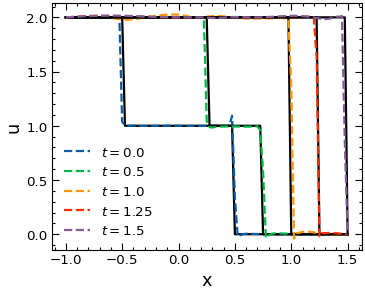

In [24]:
plt.figure(dpi=80, figsize=(5,4))

for ind in range(1, Nt_test,100):
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((Exact_y1,Exact_y2),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'k')
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
for ind in range(Nt_test+1, 2*Nt_test+1,100):
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((Exact_y1,Exact_y2),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'k')
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'--',label=fr"$t={round(Ti2+(ind-1-Nt_test)*(Tf2-Ti2)/(Nt_test-1),3)}$")

plt.xlabel("x",     fontsize=16)
plt.ylabel("u", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#
plt.show()

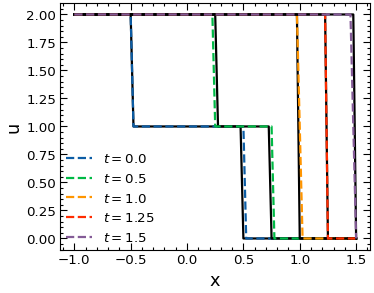

In [25]:
plt.figure(dpi=80, figsize=(5,4))#dpi=150, figsize=(10,8)
gap = 100
for ind in range(1, Nt_test+1,gap):
    xx = torch.cat((xt_test1,xt_test2),0)[0:Nx_test,:1]
    t = (ind-1)*(Tf-Ti)/(Nt_test-1)
    Exact = torch.cat((Exact_y1,Exact_y2),0)[(ind-1)*Nx_test:ind*Nx_test,0]
    pin = torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,:1]
    plt.plot(xx.detach().cpu(),Exact.detach().cpu(),'k')
    #plt.scatter(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),s=20,label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.plot(xx.detach().cpu(),initial_u(nu_pinn_train,xx-pin*t).detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
for ind in range(Nt_test+1+gap, 2*Nt_test+1,gap):
    xx = torch.cat((xt_test1,xt_test2),0)[0:Nx_test,:1]
    t = Ti2+(ind-Nt_test-1)*(Tf2-Ti2)/(Nt_test-1)
    Exact = torch.cat((Exact_y1,Exact_y2),0)[(ind-1)*Nx_test:ind*Nx_test,0]
    pin = torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,:1]
    plt.plot(xx.detach().cpu(),Exact.detach().cpu(),'k')
    #plt.scatter(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),s=20,label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.plot(xx.detach().cpu(),initial_u(nu_pinn_train,xx-pin*t).detach().cpu(),'--',label=fr"$t={round(t,3)}$")

plt.xlabel("x",     fontsize=16)
plt.ylabel("u", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(loc=(0,0),fontsize = 12)#
plt.show()

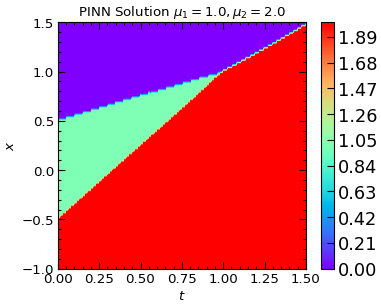

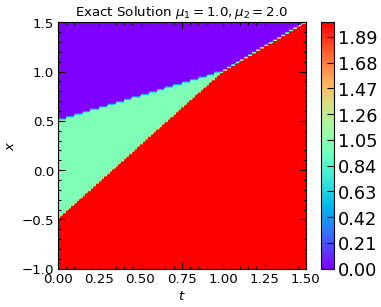

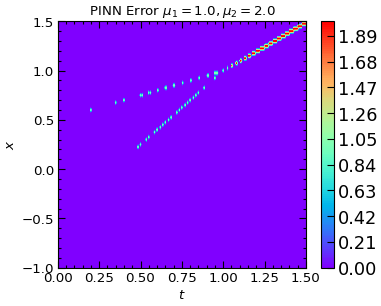

In [26]:
pin1 = PINN1(xt_test1)[:,:1].to(device)
pin2 = PINN2(xt_test2)[:,:1].to(device)
ip1 = initial_u(nu_pinn_train,xt_test1[:,:1]-pin1*xt_test1[:,1:]).to(device)
ip2 = initial_u(nu_pinn_train,xt_test2[:,:1]-pin2*xt_test2[:,1:]).to(device)
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((ip1,ip2),0),Nx_test,2*Nt_test, title=fr"PINN Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((Exact_y1,Exact_y2),0),Nx_test,2*Nt_test, title=fr"Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((abs(ip1-Exact_y1),abs(ip2-Exact_y2)),0),Nx_test,2*Nt_test, title=fr"PINN Error $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

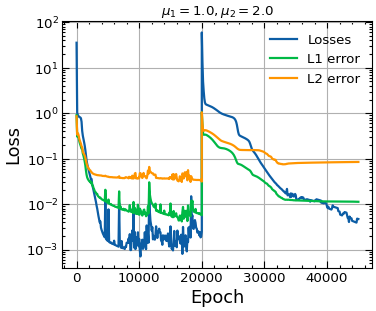

In [27]:
pinn1_losses = torch.tensor(pinn1_losses)
pinn2_losses = torch.tensor(pinn2_losses)
plt.figure(dpi=80, figsize=(5,4))    
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[1],pinn2_losses[1]),0), label="Losses")
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[2],pinn2_losses[2]),0), label="L1 error")
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[3],pinn2_losses[3]),0), label="L2 error")
#plt.plot(pinn1_losses[0], pinn1_losses[4], label="Loss_pde")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
#plt.xlim(0,max(pinn1_losses[0]))
plt.yscale('log')
plt.title(fr"$\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$", fontsize=12)
plt.legend(fontsize = 12)#
plt.show()